In [1]:
import pandas as pd
import os
import time
import numpy as np
import torch

In [3]:
#! pip install seaborn
#! pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.3/293.3 kB 10.5 MB/s eta 0:00:00


In [2]:
import seaborn as sns
from scipy import stats
from statistics import NormalDist
import matplotlib.pyplot as plt

In [3]:
torch.__version__

'1.9.0+cu111'

In [5]:
# https://stackoverflow.com/questions/66116155/how-to-tell-pytorch-which-cuda-version-to-take
#! pip install --upgrade torch==1.9.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html
#! pip install --upgrade torch==1.12.1 --extra-index-url https://download.pytorch.org/whl/cu102

In [4]:
import tensorflow as tf
#physical_devices = tf.config.list_physical_devices('CPU')
physical_devices = tf.config.list_physical_devices('GPU')

In [5]:
#tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
#device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device


device(type='cuda', index=0)

In [7]:
#test
x = torch.rand(5, 3, 
               device='cuda:0'
               )
print(x)

tensor([[0.4617, 0.0024, 0.4210],
        [0.0314, 0.2823, 0.1413],
        [0.0897, 0.6768, 0.6256],
        [0.9644, 0.8574, 0.6979],
        [0.7709, 0.4795, 0.9950]], device='cuda:0')


In [8]:
x.get_device()

0

In [11]:
#! pip install transformers
#! conda install pytorch torchvision torchaudio cudatoolkit=10.1 -c pytorch
#! pip3 install torch==1.7.0 torchvision==0.8.1 -f https://download.pytorch.org/whl/cu101/torch_stable.html
#! pip install tensorflow
! nvidia-smi

Tue Jan 10 10:03:47 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.108.03   Driver Version: 510.108.03   CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-PCI...  Off  | 00000000:61:00.0 Off |                    0 |
| N/A   31C    P0    37W / 250W |  37447MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Logits Extractor
>
> Extracting Tensor Logits from a given Neural Code Model @danaderp
>

In [9]:
def params(): 
    return {
            'big_table_path' : '../scripts/output/codesearch_tesbed_EleutherAI-gpt-neo-125M_100.csv',
            'hf_model' : 'EleutherAI/gpt-neo-125M' 
}

In [10]:
#pwd
parameters = params()
parameters['big_table_path']

'../scripts/output/codesearch_tesbed_EleutherAI-gpt-neo-125M_100.csv'

# Data Upload

In [14]:
data_pd = pd.read_csv( 
                      parameters['big_table_path'] , 
                      index_col=0
            )

In [15]:
data_pd.describe()

,model_total_input_ids
count,100.000000
mean,376.370000
std,314.333531
min,55.000000
25%,159.500000
50%,260.500000
75%,480.000000
max,1969.000000


In [16]:
data_pd.head(5)

,whole_func_string,ast_concepts,model_tokenizer_concepts,model_input_ids,model_total_input_ids
0,"def get_node(self, label):\n """"""\n ...","[('def', 'def', 'function_definition'), ('get_...","[(4299, 'def', 'function_definition'), (651, '...","[4299, 651, 62, 17440, 7, 944, 11, 6167, 2599,...",115
1,"def execute_pipeline(pipeline, environment_dic...","[('def', 'def', 'function_definition'), ('exec...","[(4299, 'def', 'function_definition'), (12260,...","[4299, 12260, 62, 79, 541, 4470, 7, 79, 541, 4...",492
2,"def _decode(self, data):\n '''\n ...","[('def', 'def', 'function_definition'), ('_dec...","[(4299, 'def', 'function_definition'), (4808, ...","[4299, 4808, 12501, 1098, 7, 944, 11, 1366, 25...",583
3,"def _repr_html_(self):\n """"""\n J...","[('def', 'def', 'function_definition'), ('_rep...","[(4299, 'def', 'function_definition'), (4808, ...","[4299, 4808, 260, 1050, 62, 6494, 41052, 944, ...",221
4,"def build_shape(relation, nodes, ways):\n ""...","[('def', 'def', 'function_definition'), ('buil...","[(4299, 'def', 'function_definition'), (1382, ...","[4299, 1382, 62, 43358, 7, 49501, 11, 13760, 1...",454


In [17]:
data_pd['model_tokenizer_concepts'][0]

"[(4299, 'def', 'function_definition'), (651, 'identifier', 'function_definition'), (62, 'identifier', 'function_definition'), (17440, 'identifier', 'function_definition'), (7, '(', 'parameters'), (944, 'identifier', 'parameters'), (11, ',', 'parameters'), (6167, 'identifier', 'parameters'), (2599, ')', 'parameters'), (198, 'ERROR', 'ERROR'), (220, 'ERROR', 'ERROR'), (220, 'ERROR', 'ERROR'), (220, 'ERROR', 'ERROR'), (220, 'ERROR', 'ERROR'), (220, 'ERROR', 'ERROR'), (220, 'ERROR', 'ERROR'), (220, 'ERROR', 'ERROR'), (37227, 'string', 'expression_statement'), (198, 'string', 'expression_statement'), (220, 'string', 'expression_statement'), (220, 'string', 'expression_statement'), (220, 'string', 'expression_statement'), (220, 'string', 'expression_statement'), (220, 'string', 'expression_statement'), (220, 'string', 'expression_statement'), (220, 'string', 'expression_statement'), (29620, 'string', 'expression_statement'), (262, 'string', 'expression_statement'), (7368, 'string', 'express

In [18]:
data_pd.ast_concepts.values[0][2]

"'"

In [19]:
data_pd.whole_func_string.values[0]

'def get_node(self, label):\n        """\n        Gets the specified node by name.\n\n        :return: Node or None if name does not exist in tree\n        """\n        for n in self.walk():\n            if n.name == label:\n                return n'

In [20]:
data_pd.whole_func_string.values[0][:100]

'def get_node(self, label):\n        """\n        Gets the specified node by name.\n\n        :return: No'

# Model Upload

In [21]:
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import pipeline

In [22]:
#pip list
#! pip install git+https://github.com/huggingface/transfomers.git


In [23]:
#tokenizer = AutoTokenizer.from_pretrained("Salesforce/codegen-2B-mono")
#tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-j-6B")
#generator = pipeline('text-generation', model='EleutherAI/gpt-neo-1.3B')
#model = AutoModelForCausalLM.from_pretrained("EleutherAI/gpt-j-6B")
generator = pipeline('text-generation', model='EleutherAI/gpt-neo-125M')


In [24]:
generator("EleutherAI has", do_sample=True, min_length=20)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/home/svelascodimate/miniconda3/envs/code-syntax-concept/lib/python3.10/site-packages/transformers/generation_utils.py:1202: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 20 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'EleutherAI has not received any payment for the full period of the transaction, but it is expected'}]

In [25]:
generator( data_pd.whole_func_string.values[0][:100], do_sample=True, min_length=20 )


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Input length of input_ids is 45, but `max_length` is set to 20. This can lead to unexpected behavior. You should consider increasing `max_new_tokens`.


[{'generated_text': 'def get_node(self, label):\n        """\n        Gets the specified node by name.\n\n        :return: No node'}]

In [26]:
generator2 = pipeline('text-generation', model='EleutherAI/gpt-neo-1.3B')


In [27]:
generator2("for(int i= ", do_sample=True, min_length=50)

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/home/svelascodimate/miniconda3/envs/code-syntax-concept/lib/python3.10/site-packages/transformers/generation_utils.py:1202: UserWarning: Neither `max_length` nor `max_new_tokens` have been set, `max_length` will default to 50 (`self.config.max_length`). Controlling `max_length` via the config is deprecated and `max_length` will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': 'for(int i=  0, j=0; i!= j; i, j+=1 )\n{\n    A[i] += B[j] * C[i];\n}\n\nreturn (double)'}]

In [28]:
generator2( data_pd.whole_func_string.values[0][:100], do_sample=True, max_new_tokens=50 )

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'def get_node(self, label):\n        """\n        Gets the specified node by name.\n\n        :return: No-op\n        """\n        return self.__class__(self, label)\n\n    def delete_node(self, label):\n      '}]

# Extracting Logits From a Given Model

In [29]:
from transformers import GPTNeoForCausalLM, GPT2Tokenizer
model = GPTNeoForCausalLM.from_pretrained( parameters['hf_model'] )
tokenizer = GPT2Tokenizer.from_pretrained( parameters['hf_model'] )

In [30]:
tokenizer.get_vocab()

{'!': 0,
 '"': 1,
 '#': 2,
 '$': 3,
 '%': 4,
 '&': 5,
 "'": 6,
 '(': 7,
 ')': 8,
 '*': 9,
 '+': 10,
 ',': 11,
 '-': 12,
 '.': 13,
 '/': 14,
 '0': 15,
 '1': 16,
 '2': 17,
 '3': 18,
 '4': 19,
 '5': 20,
 '6': 21,
 '7': 22,
 '8': 23,
 '9': 24,
 ':': 25,
 ';': 26,
 '<': 27,
 '=': 28,
 '>': 29,
 '?': 30,
 '@': 31,
 'A': 32,
 'B': 33,
 'C': 34,
 'D': 35,
 'E': 36,
 'F': 37,
 'G': 38,
 'H': 39,
 'I': 40,
 'J': 41,
 'K': 42,
 'L': 43,
 'M': 44,
 'N': 45,
 'O': 46,
 'P': 47,
 'Q': 48,
 'R': 49,
 'S': 50,
 'T': 51,
 'U': 52,
 'V': 53,
 'W': 54,
 'X': 55,
 'Y': 56,
 'Z': 57,
 '[': 58,
 '\\': 59,
 ']': 60,
 '^': 61,
 '_': 62,
 '`': 63,
 'a': 64,
 'b': 65,
 'c': 66,
 'd': 67,
 'e': 68,
 'f': 69,
 'g': 70,
 'h': 71,
 'i': 72,
 'j': 73,
 'k': 74,
 'l': 75,
 'm': 76,
 'n': 77,
 'o': 78,
 'p': 79,
 'q': 80,
 'r': 81,
 's': 82,
 't': 83,
 'u': 84,
 'v': 85,
 'w': 86,
 'x': 87,
 'y': 88,
 'z': 89,
 '{': 90,
 '|': 91,
 '}': 92,
 '~': 93,
 '¡': 94,
 '¢': 95,
 '£': 96,
 '¤': 97,
 '¥': 98,
 '¦': 99,
 '§': 100

In [31]:
len( tokenizer.get_vocab() ) #todo an assert

50257

In [32]:
#prompts = data_pd.whole_func_string.values[:2]
prompts = data_pd.whole_func_string.values

In [33]:
len(prompts)

100

In [34]:
prompts[:2]

array(['def get_node(self, label):\n        """\n        Gets the specified node by name.\n\n        :return: Node or None if name does not exist in tree\n        """\n        for n in self.walk():\n            if n.name == label:\n                return n',
       'def execute_pipeline(pipeline, environment_dict=None, run_config=None):\n    \'\'\'\n    "Synchronous" version of :py:func:`execute_pipeline_iterator`.\n\n    Note: raise_on_error is very useful in testing contexts when not testing for error\n    conditions\n\n    Parameters:\n      pipeline (PipelineDefinition): Pipeline to run\n      environment_dict (dict): The enviroment configuration that parameterizes this run\n      run_config (RunConfig): Configuration for how this pipeline will be executed\n\n    Returns:\n      :py:class:`PipelineExecutionResult`\n    \'\'\'\n\n    check.inst_param(pipeline, \'pipeline\', PipelineDefinition)\n    environment_dict = check.opt_dict_param(environment_dict, \'environment_dict\')\n    

In [35]:
#tokenized_code = tokenizer(prompt, return_tensors="pt")
#input_ids = tokenized_code.input_ids #tst

In [36]:
#Making space for the tensors
input_ids_list = tokenizer.batch_encode_plus( prompts )
input_ids_list = [torch.Tensor( np.array( input_ids ) ) for input_ids in input_ids_list.input_ids if len(input_ids) <= 2048]

In [37]:
len(input_ids_list)

100

In [38]:
data_pd.model_input_ids.values[0]

'[4299, 651, 62, 17440, 7, 944, 11, 6167, 2599, 198, 220, 220, 220, 220, 220, 220, 220, 37227, 198, 220, 220, 220, 220, 220, 220, 220, 29620, 262, 7368, 10139, 416, 1438, 13, 628, 220, 220, 220, 220, 220, 220, 220, 1058, 7783, 25, 19081, 393, 6045, 611, 1438, 857, 407, 2152, 287, 5509, 198, 220, 220, 220, 220, 220, 220, 220, 37227, 198, 220, 220, 220, 220, 220, 220, 220, 329, 299, 287, 2116, 13, 11152, 33529, 198, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 611, 299, 13, 3672, 6624, 6167, 25, 198, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 220, 1441, 299]'

In [39]:
input_ids_list[0]

tensor([4.2990e+03, 6.5100e+02, 6.2000e+01, 1.7440e+04, 7.0000e+00, 9.4400e+02,
        1.1000e+01, 6.1670e+03, 2.5990e+03, 1.9800e+02, 2.2000e+02, 2.2000e+02,
        2.2000e+02, 2.2000e+02, 2.2000e+02, 2.2000e+02, 2.2000e+02, 3.7227e+04,
        1.9800e+02, 2.2000e+02, 2.2000e+02, 2.2000e+02, 2.2000e+02, 2.2000e+02,
        2.2000e+02, 2.2000e+02, 2.9620e+04, 2.6200e+02, 7.3680e+03, 1.0139e+04,
        4.1600e+02, 1.4380e+03, 1.3000e+01, 6.2800e+02, 2.2000e+02, 2.2000e+02,
        2.2000e+02, 2.2000e+02, 2.2000e+02, 2.2000e+02, 2.2000e+02, 1.0580e+03,
        7.7830e+03, 2.5000e+01, 1.9081e+04, 3.9300e+02, 6.0450e+03, 6.1100e+02,
        1.4380e+03, 8.5700e+02, 4.0700e+02, 2.1520e+03, 2.8700e+02, 5.5090e+03,
        1.9800e+02, 2.2000e+02, 2.2000e+02, 2.2000e+02, 2.2000e+02, 2.2000e+02,
        2.2000e+02, 2.2000e+02, 3.7227e+04, 1.9800e+02, 2.2000e+02, 2.2000e+02,
        2.2000e+02, 2.2000e+02, 2.2000e+02, 2.2000e+02, 2.2000e+02, 3.2900e+02,
        2.9900e+02, 2.8700e+02, 2.1160e+

In [40]:
torch.cuda

<module 'torch.cuda' from '/home/svelascodimate/miniconda3/envs/code-syntax-concept/lib/python3.10/site-packages/torch/cuda/__init__.py'>

In [41]:
len(input_ids_list) #Filtered Window

100

In [42]:
tokenizer.decode( input_ids_list[0] ) #Decoding IDs

'def get_node(self, label):\n        """\n        Gets the specified node by name.\n\n        :return: Node or None if name does not exist in tree\n        """\n        for n in self.walk():\n            if n.name == label:\n                return n'

In [43]:
model.to( 'cpu' ) #WARNING, Changed it later to GPU

GPTNeoForCausalLM(
  (transformer): GPTNeoModel(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.0, inplace=False)
    (h): ModuleList(
      (0): GPTNeoBlock(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPTNeoAttention(
          (attention): GPTNeoSelfAttention(
            (attn_dropout): Dropout(p=0.0, inplace=False)
            (resid_dropout): Dropout(p=0.0, inplace=False)
            (k_proj): Linear(in_features=768, out_features=768, bias=False)
            (v_proj): Linear(in_features=768, out_features=768, bias=False)
            (q_proj): Linear(in_features=768, out_features=768, bias=False)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPTNeoMLP(
          (c_fc): Linear(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear(in_features=3

In [44]:
#Output is the class CausalLMOutputWithPast (https://huggingface.co/transformers/v4.10.1/main_classes/output.html?highlight=causallmoutputwithpast)
#logits (torch.FloatTensor of shape (batch_size, sequence_length, config.vocab_size)) – Prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).
# output = model(input_ids=input_ids)
# [WARNING TAKES TIME]
output = [ model( input_ids = i.to(torch.int64) ) for i in input_ids_list ]

In [45]:
output_logits = [ o.logits for o in output ]

In [46]:
#Based on the response here: https://stackoverflow.com/questions/62852940/how-to-get-immediate-next-word-probability-using-gpt2-model
# next_token_logits = output[0][:, -1, :] #last token
output_logits[1].shape #The loggits contains the information of the next token prediction given the prevous windows w_{<t}

torch.Size([492, 50257])

In [47]:
output_logits[1][0]

tensor([ -5.6059,  -2.4399,  -6.9557,  ..., -11.8578, -14.6071,  -6.0799],
       grad_fn=<SelectBackward0>)

In [48]:
sum( output_logits[1][0] ) #non-normalized tokens summup different than 1

tensor(-553420.9375, grad_fn=<AddBackward0>)

In [49]:
soft = torch.nn.Softmax( dim = 0 ) #Flattening normalization
next_token_distribution = soft( output_logits[1][0] ) #Flattening normalization

In [50]:
next_token_distribution.shape

torch.Size([50257])

## Batch Softmax Distribution

In [51]:
output_logits

[tensor([[ -5.6059,  -2.4399,  -6.9557,  ..., -11.8578, -14.6071,  -6.0799],
         [ -6.2990,  -3.9610,  -6.1833,  ..., -10.6406,  -8.8349,  -6.3452],
         [ -4.8018,  -4.1277,  -4.1619,  ...,  -8.1974,  -7.6979,  -6.0528],
         ...,
         [-11.9002, -11.7730,  -8.0985,  ..., -15.8561, -17.3783, -11.6446],
         [ -7.4098,  -9.9632, -12.2038,  ..., -18.2707, -18.1764, -10.3717],
         [-10.0745,  -9.8232, -12.0393,  ..., -25.0120, -21.1442,  -8.6445]],
        grad_fn=<MmBackward0>),
 tensor([[ -5.6059,  -2.4399,  -6.9557,  ..., -11.8578, -14.6071,  -6.0799],
         [ -3.2613,  -3.4885,  -7.5667,  ..., -14.2281, -14.1252,  -6.1792],
         [ -4.1326,  -5.6764,  -5.4887,  ..., -12.1207, -11.4404,  -7.5004],
         ...,
         [-25.2886, -25.3481, -24.2219,  ..., -32.4984, -33.6202, -15.5898],
         [-23.1931, -22.4658, -20.3607,  ..., -23.5468, -28.6755, -14.5011],
         [-16.4041, -14.7310, -12.8584,  ..., -31.2271, -25.5518,  -5.8683]],
        grad_f

In [52]:
next_token_distributions = [ [soft( logits ) for logits in prompt_tesor]  for prompt_tesor in output_logits ]

In [53]:
sum( next_token_distributions[0][0] ) #tst

tensor(1.0000, grad_fn=<AddBackward0>)

In [54]:
def topk_tuple( vocab_token, largest):
    token_position_dict = list( tokenizer.get_vocab().keys() )
    topk = vocab_token.topk( k=1 , largest=largest ) #TODO K number of elements can be extended
    return ( token_position_dict[topk.indices], topk.values)

### MAX Case

In [55]:
#maximum case
#return A namedtuple of (values, indices)
#If Largest True then search for the max case
max_logit_token_prompt = [[ topk_tuple(vocab_token=vocab_token, largest=True) for vocab_token in prompt ] for prompt in next_token_distributions ]
max_logit_token_prompt

[[('ers', tensor([0.0308], grad_fn=<TopkBackward0>)),
  ('_', tensor([0.2419], grad_fn=<TopkBackward0>)),
  ('name', tensor([0.0194], grad_fn=<TopkBackward0>)),
  ('_', tensor([0.4209], grad_fn=<TopkBackward0>)),
  ('node', tensor([0.2215], grad_fn=<TopkBackward0>)),
  (',', tensor([0.4757], grad_fn=<TopkBackward0>)),
  ('Ġnode', tensor([0.1696], grad_fn=<TopkBackward0>)),
  (',', tensor([0.3714], grad_fn=<TopkBackward0>)),
  ('Ċ', tensor([0.9505], grad_fn=<TopkBackward0>)),
  ('Ġ', tensor([0.9688], grad_fn=<TopkBackward0>)),
  ('Ġ', tensor([0.9873], grad_fn=<TopkBackward0>)),
  ('Ġ', tensor([0.9983], grad_fn=<TopkBackward0>)),
  ('Ġ', tensor([0.4134], grad_fn=<TopkBackward0>)),
  ('Ġ', tensor([0.9901], grad_fn=<TopkBackward0>)),
  ('Ġ', tensor([0.9468], grad_fn=<TopkBackward0>)),
  ('Ġ', tensor([0.9975], grad_fn=<TopkBackward0>)),
  ('Ġ"""', tensor([0.1968], grad_fn=<TopkBackward0>)),
  ('Ċ', tensor([0.4083], grad_fn=<TopkBackward0>)),
  ('Ġ', tensor([0.9993], grad_fn=<TopkBackward0>)

In [56]:
data_pd['max_prob_case'] = max_logit_token_prompt

In [57]:
data_pd.head(1)

,whole_func_string,ast_concepts,model_tokenizer_concepts,model_input_ids,model_total_input_ids,max_prob_case
0,"def get_node(self, label):\n """"""\n ...","[('def', 'def', 'function_definition'), ('get_...","[(4299, 'def', 'function_definition'), (651, '...","[4299, 651, 62, 17440, 7, 944, 11, 6167, 2599,...",115,"[(ers, [tensor(0.0308, grad_fn=<UnbindBackward..."


### MIN Case

In [58]:
#minimum case
min_logit_token_prompt = [[ topk_tuple(vocab_token=vocab_token, largest=False) for vocab_token in prompt ] for prompt in next_token_distributions ]

In [59]:
data_pd['min_prob_case'] = min_logit_token_prompt
data_pd.head(1)

,whole_func_string,ast_concepts,model_tokenizer_concepts,model_input_ids,model_total_input_ids,max_prob_case,min_prob_case
0,"def get_node(self, label):\n """"""\n ...","[('def', 'def', 'function_definition'), ('get_...","[(4299, 'def', 'function_definition'), (651, '...","[4299, 651, 62, 17440, 7, 944, 11, 6167, 2599,...",115,"[(ers, [tensor(0.0308, grad_fn=<UnbindBackward...","[(anwhile, [tensor(1.0384e-16, grad_fn=<Unbind..."


### Actual Token Case

In [60]:
#actual token case
actual_logit_token_prompt = []
token_position_dict = list( tokenizer.get_vocab().keys() )
for p,prompt in enumerate( input_ids_list ):
    temp_prompt = []
    for c,code_token_position in enumerate( prompt[1:] ): #Eliminate the first token prediction since we do not use it
        temp_prompt.append( 
                ( token_position_dict[int(code_token_position)],next_token_distributions[ p ][ c ][int(code_token_position)] )        
            )
    actual_logit_token_prompt.append( temp_prompt )

In [61]:
data_pd['actual_prob_case'] = actual_logit_token_prompt
data_pd.head(1)

,whole_func_string,ast_concepts,model_tokenizer_concepts,model_input_ids,model_total_input_ids,max_prob_case,min_prob_case,actual_prob_case
0,"def get_node(self, label):\n """"""\n ...","[('def', 'def', 'function_definition'), ('get_...","[(4299, 'def', 'function_definition'), (651, '...","[4299, 651, 62, 17440, 7, 944, 11, 6167, 2599,...",115,"[(ers, [tensor(0.0308, grad_fn=<UnbindBackward...","[(anwhile, [tensor(1.0384e-16, grad_fn=<Unbind...","[(Ġget, tensor(0.0024, grad_fn=<SelectBackward..."


In [90]:
dataframe_to_save = data_pd.copy()
dataframe_to_save['max_prob_case'] = dataframe_to_save['max_prob_case'].map(lambda max_prob: [(value[0], value[1].item()) for value in max_prob ])
dataframe_to_save['min_prob_case'] = dataframe_to_save['min_prob_case'].map(lambda min_prob: [(value[0], value[1].item()) for value in min_prob ])
dataframe_to_save['actual_prob_case'] = dataframe_to_save['actual_prob_case'].map(lambda actual_prob: [(value[0], value[1].item()) for value in actual_prob ])
dataframe_to_save.head()
#dataframe_to_save.iloc[0]['actual_prob_case'][0]

,whole_func_string,ast_concepts,model_tokenizer_concepts,model_input_ids,model_total_input_ids,max_prob_case,min_prob_case,actual_prob_case
0,"def get_node(self, label):\n """"""\n ...","[('def', 'def', 'function_definition'), ('get_...","[(4299, 'def', 'function_definition'), (651, '...","[4299, 651, 62, 17440, 7, 944, 11, 6167, 2599,...",115,"[(ers, 0.03083181567490101), (_, 0.24190878868...","[(anwhile, 1.03836617568492e-16), (ousy, 3.281...","[(Ġget, 0.0024285861290991306), (_, 0.24190878..."
1,"def execute_pipeline(pipeline, environment_dic...","[('def', 'def', 'function_definition'), ('exec...","[(4299, 'def', 'function_definition'), (12260,...","[4299, 12260, 62, 79, 541, 4470, 7, 79, 541, 4...",492,"[(ers, 0.03083181567490101), (_, 0.18530689179...","[(anwhile, 1.03836617568492e-16), (icester, 3....","[(Ġexecute, 5.97450380155351e-05), (_, 0.18530..."
2,"def _decode(self, data):\n '''\n ...","[('def', 'def', 'function_definition'), ('_dec...","[(4299, 'def', 'function_definition'), (4808, ...","[4299, 4808, 12501, 1098, 7, 944, 11, 1366, 25...",583,"[(ers, 0.03083181567490101), ((, 0.01664732024...","[(anwhile, 1.03836617568492e-16), (ousy, 4.688...","[(Ġ_, 0.001834857277572155), (dec, 0.001334611..."
3,"def _repr_html_(self):\n """"""\n J...","[('def', 'def', 'function_definition'), ('_rep...","[(4299, 'def', 'function_definition'), (4808, ...","[4299, 4808, 260, 1050, 62, 6494, 41052, 944, ...",221,"[(ers, 0.03083181567490101), ((, 0.01664732024...","[(anwhile, 1.03836617568492e-16), (ousy, 4.688...","[(Ġ_, 0.001834857277572155), (re, 0.0013783742..."
4,"def build_shape(relation, nodes, ways):\n ""...","[('def', 'def', 'function_definition'), ('buil...","[(4299, 'def', 'function_definition'), (1382, ...","[4299, 1382, 62, 43358, 7, 49501, 11, 13760, 1...",454,"[(ers, 0.03083181567490101), (_, 0.28421667218...","[(anwhile, 1.03836617568492e-16), (buquerque, ...","[(Ġbuild, 0.0005856865900568664), (_, 0.284216..."


In [91]:
## Saving File
#data_pd.to_csv( 'output/testbed_base_EleutherAI-gpt-neo-125M.csv' )
dataframe_to_save.to_csv( 'output/testbed_base_EleutherAI-gpt-neo-125M.csv' )

## Statistical Analysis

In [64]:
len(data_pd.actual_prob_case.values[0])

114

In [65]:
data_pd.actual_prob_case.values[0][-2]

('Ġreturn', tensor(0.3918, grad_fn=<SelectBackward0>))

In [66]:
tokenizer.get_vocab()['Ġreturn']

1441

In [67]:
child_logits = {}
parent_logits = {}

for i,sequence in enumerate( data_pd.actual_prob_case.values ):
    #print(sequence)
    tok_tuple_list = eval( data_pd.model_tokenizer_concepts.values[i] )
    for j,label_tuple in enumerate( tok_tuple_list[1:] ): #Dropping first token
        if label_tuple[1] in set( child_logits.keys() ):
            #print('in',label_tuple,sequence[j])
            child_logits[label_tuple[1]].append( sequence[j][1] )
        else:
            #print('out',label_tuple,sequence[j])
            child_logits[label_tuple[1]] = []
            child_logits[label_tuple[1]].append( sequence[j][1] )
            
        ### PARENT
        if label_tuple[1] in set( parent_logits.keys() ):
            #print('in',label_tuple,sequence[j])
            parent_logits[label_tuple[2]].append( sequence[j][1] )
        else:
            #print('out',label_tuple,sequence[j])
            parent_logits[label_tuple[2]] = []
            parent_logits[label_tuple[2]].append( sequence[j][1] )

In [68]:
parent_logits['ERROR'][0]

tensor(0.9505, grad_fn=<SelectBackward0>)

In [69]:
parent_logits.keys()

dict_keys(['function_definition', 'parameters', 'ERROR', 'expression_statement', 'for_statement', 'attribute', 'argument_list', 'if_statement', 'comparison_operator', 'return_statement', 'default_parameter', 'assignment', 'call', 'with_statement', 'as_pattern', 'as_pattern_target', 'lambda', 'subscript', 'elif_clause', 'raise_statement', 'concatenated_string', 'binary_operator', 'tuple', 'keyword_argument', 'boolean_operator', 'else_clause', 'list_comprehension', 'for_in_clause', 'pattern_list', 'augmented_assignment', 'yield', 'continue_statement', 'pass_statement', 'block', 'slice', 'try_statement', 'except_clause', 'typed_parameter', 'type', 'expression_list', 'dictionary', 'list', 'unary_operator', 'dictionary_splat', 'list_splat_pattern', 'dictionary_splat_pattern', 'parenthesized_expression', 'not_operator', 'while_statement', 'pair', 'assert_statement', 'import_statement', 'dotted_name', 'finally_clause', 'if_clause', 'print_statement', 'lambda_parameters', 'conditional_expressi

In [70]:
[ (elem,np.mean( [np_elem.detach().numpy() for np_elem in parent_logits[elem] ] )) for elem in parent_logits.keys()]

[('function_definition', 0.00685613),
 ('parameters', 0.05422731),
 ('ERROR', 0.95655394),
 ('expression_statement', 0.5756459),
 ('for_statement', 0.94806695),
 ('attribute', 0.695894),
 ('argument_list', 0.65822536),
 ('if_statement', 0.19331357),
 ('comparison_operator', 0.003126347),
 ('return_statement', 0.011329593),
 ('default_parameter', 0.07833512),
 ('assignment', 0.22890994),
 ('call', 0.034673534),
 ('with_statement', 0.007119442),
 ('as_pattern', 0.5397769),
 ('as_pattern_target', 0.6983771),
 ('lambda', 0.019942557),
 ('subscript', 0.90088713),
 ('elif_clause', 0.99947935),
 ('raise_statement', 0.73013324),
 ('concatenated_string', 0.09667651),
 ('binary_operator', 0.9962972),
 ('tuple', 0.54704726),
 ('keyword_argument', 0.80122626),
 ('boolean_operator', 0.17651677),
 ('else_clause', 0.9988009),
 ('list_comprehension', 0.06761814),
 ('for_in_clause', 0.9986658),
 ('pattern_list', 0.0775634),
 ('augmented_assignment', 0.8450097),
 ('yield', 0.5540593),
 ('continue_statem

In [71]:
[ (elem,np.mean( [np_elem.detach().numpy() for np_elem in child_logits[elem] ] )) for elem in child_logits.keys()]

[('identifier', 0.4812328),
 ('(', 0.5522684),
 (',', 0.51526713),
 (')', 0.52844435),
 ('ERROR', 0.95655394),
 ('string', 0.56107783),
 ('for', 0.17312898),
 ('in', 0.7019869),
 ('.', 0.71138686),
 ('if', 0.25024143),
 ('==', 0.5628831),
 (':', 0.76923716),
 ('return', 0.25153485),
 ('=', 0.69708586),
 ('none', 0.5275026),
 ('with', 0.015638953),
 ('as', 0.7626169),
 ('lambda', 0.003509973),
 ('[', 0.5783372),
 (']', 0.60399276),
 ('elif', 0.6839436),
 ('not', 0.32989264),
 ('raise', 0.3958262),
 ('%', 0.8124865),
 ('and', 0.22879925),
 ('is', 0.4186844),
 ('else', 0.29153687),
 ('+=', 0.54749405),
 ('integer', 0.3698103),
 ('yield', 0.054823637),
 ('comment', 0.3349653),
 ('continue', 0.30500975),
 ('pass', 0.10833486),
 ('*=', 0.45581686),
 ('true', 0.4172525),
 ('false', 0.4126358),
 ('try', 0.034667786),
 ('except', 0.64124024),
 ('->', 0.7081914),
 ('}', 0.4993427),
 ('-', 0.28293025),
 ('+', 0.38528565),
 ('**', 0.22476354),
 ('*', 0.2793513),
 ('or', 0.19759507),
 ('<', 0.06799

## Bootstrapping 

In [72]:
#export
def bootstrapping( np_data, np_func, size ):
    """Create a bootstrap sample given data and a function
    For instance, a bootstrap sample of means, or mediands. 
    The bootstrap replicates are a long as the original size
    we can choose any observation more than once (resampling with replacement:np.random.choice)
    """
    
    #Cleaning NaNs
    #np_data_clean = np_data[ np.logical_not( np.isnan(np_data) ) ] 
    
    #The size of the bootstrap replicate is as big as size
    #Creating the boostrap replicates as long as the orignal data size
    #This strategy might work as imputation 
    bootstrap_repl = [ np_func( np.random.choice( np_data, size=len(np_data) ) ) for i in range( size ) ]
    
    #logging.info("Covariate: " + cov) #Empirical Mean
    #logging.info("Empirical Mean: " + str(np.mean(np_data_clean))) #Empirical Mean
    #logging.info("Bootstrapped Mean: " + str( np.mean(bootstrap_repl) ) ) #Bootstrapped Mean
    
    return np.array( bootstrap_repl )

In [73]:
def dictionary_boots( dict_concepts, np_func = np.mean, size=500):
    np_dettached = lambda np_ccp: np.array([ np_elem.detach().numpy() for np_elem in np_ccp ]).flatten()
    return {ccp: bootstrapping(np_dettached( dict_concepts[ccp] ), np_func, size) for ccp in dict_concepts.keys()}

In [74]:
dict_test = dictionary_boots(
    dict_concepts = parent_logits
)

In [75]:
pd_test_bs = pd.DataFrame.from_dict( dict_test )

In [76]:
pd_test_bs.head()

,function_definition,parameters,ERROR,expression_statement,for_statement,attribute,argument_list,if_statement,comparison_operator,return_statement,...,conditional_expression,import_from_statement,await,list_splat,delete_statement,class_definition,generator_expression,break_statement,import_prefix,aliased_import
0,0.006856,0.054227,0.959039,0.575646,0.948067,0.695894,0.658225,0.193314,0.003126,0.01133,...,0.201742,0.736156,0.048455,0.99857,0.023044,0.71382,0.211027,0.333624,0.860952,0.996152
1,0.006856,0.054227,0.956497,0.575646,0.948067,0.695894,0.658225,0.193314,0.003126,0.01133,...,0.201742,0.736156,0.001797,0.99857,0.023044,0.71382,0.211027,0.333624,0.860952,0.996152
2,0.006856,0.054227,0.958465,0.575646,0.948067,0.695894,0.658225,0.193314,0.003126,0.01133,...,0.201742,0.736156,0.048455,0.99857,0.023044,0.71382,0.211027,0.333624,0.860952,0.996152
3,0.006856,0.054227,0.957224,0.575646,0.948067,0.695894,0.658225,0.193314,0.003126,0.01133,...,0.201742,0.736156,0.001797,0.99857,0.023044,0.71382,0.211027,0.333624,0.860952,0.996152
4,0.006856,0.054227,0.957488,0.575646,0.948067,0.695894,0.658225,0.193314,0.003126,0.01133,...,0.201742,0.736156,0.046910,0.99857,0.023044,0.71382,0.211027,0.333624,0.860952,0.996152


In [77]:
pd_test_bs.describe()

,function_definition,parameters,ERROR,expression_statement,for_statement,attribute,argument_list,if_statement,comparison_operator,return_statement,...,conditional_expression,import_from_statement,await,list_splat,delete_statement,class_definition,generator_expression,break_statement,import_prefix,aliased_import
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.00000,...,500.000000,500.000000,500.000000,500.00000,500.000000,500.00000,500.000000,500.000000,500.000000,500.000000
mean,0.006856,0.054227,0.956544,0.575646,0.948067,0.695894,0.658225,0.193314,0.003126,0.01133,...,0.201742,0.736156,0.023902,0.99857,0.023044,0.71382,0.211027,0.333624,0.860951,0.996152
std,0.000000,0.000000,0.001141,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.018887,0.00000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000
min,0.006856,0.054227,0.953238,0.575646,0.948067,0.695894,0.658225,0.193314,0.003126,0.01133,...,0.201742,0.736156,0.000241,0.99857,0.023044,0.71382,0.211027,0.333624,0.860952,0.996152
25%,0.006856,0.054227,0.955853,0.575646,0.948067,0.695894,0.658225,0.193314,0.003126,0.01133,...,0.201742,0.736156,0.003342,0.99857,0.023044,0.71382,0.211027,0.333624,0.860952,0.996152
50%,0.006856,0.054227,0.956471,0.575646,0.948067,0.695894,0.658225,0.193314,0.003126,0.01133,...,0.201742,0.736156,0.025120,0.99857,0.023044,0.71382,0.211027,0.333624,0.860952,0.996152
75%,0.006856,0.054227,0.957293,0.575646,0.948067,0.695894,0.658225,0.193314,0.003126,0.01133,...,0.201742,0.736156,0.028210,0.99857,0.023044,0.71382,0.211027,0.333624,0.860952,0.996152
max,0.006856,0.054227,0.959541,0.575646,0.948067,0.695894,0.658225,0.193314,0.003126,0.01133,...,0.201742,0.736156,0.093578,0.99857,0.023044,0.71382,0.211027,0.333624,0.860952,0.996152


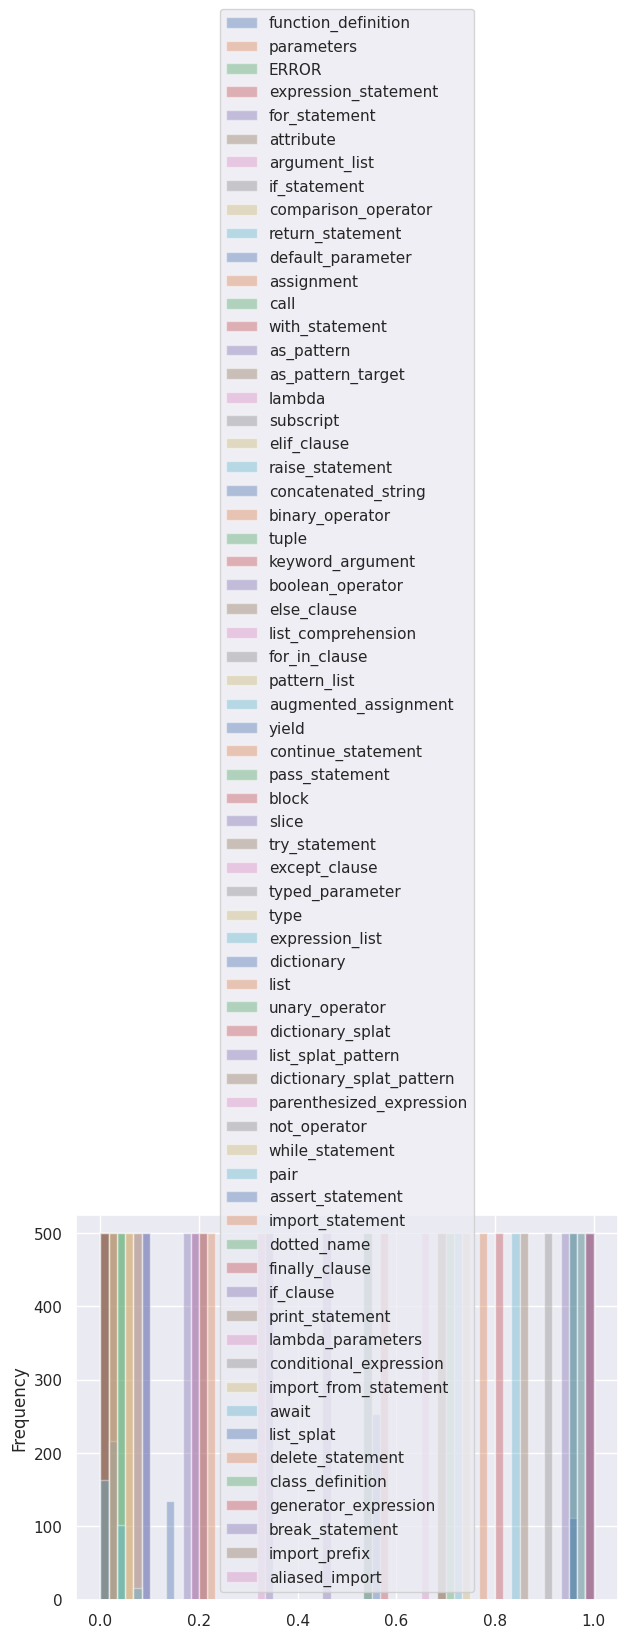

In [78]:
sns.set_theme(style="darkgrid")
#ax = pd_test_bs.plot.kde()
pd_test_bs.plot.hist(
    bins=60, 
    alpha=0.4,
    figsize=(7,5)
)
plt.show()

In [79]:
assert len(dict_test['function_definition']) == len(dict_test['argument_list']) 

In [80]:
#export
#We use normal distribution assuming the sample size is big enough (~more than 100 points)
def confidence_intervals_v1(np_data_bs, conf=0.95):
    """Confidence Intervals with Gaussian Distribution (n>=30)"""
    CI = stats.norm.interval(alpha=conf, loc = np.mean( np_data_bs ), scale = stats.sem(np_data_bs))
    return CI

In [81]:
#export
#see https://stackoverflow.com/questions/15033511/compute-a-confidence-interval-from-sample-data
def confidence_intervals_v2(data, confidence=0.95):
    dist = NormalDist.from_samples(data)
    z = NormalDist().inv_cdf((1 + confidence) / 2.)
    h = dist.stdev * z / ((len(data) - 1) ** .5)
    return dist.mean - h, dist.mean + h, h

In [82]:
dict_test_intervals = {k: confidence_intervals_v2(dict_test[k]) for k in dict_test.keys() }

In [83]:
dict_test_intervals

{'function_definition': (0.0068561299704015255, 0.0068561299704015255, 0.0),
 'parameters': (0.0542273111641407, 0.0542273111641407, 0.0),
 'ERROR': (0.956443747356256, 0.9566439573022522, 0.00010010497299804829),
 'expression_statement': (0.575645923614502, 0.575645923614502, 0.0),
 'for_statement': (0.9480669498443604, 0.9480669498443604, 0.0),
 'attribute': (0.6958940029144287, 0.6958940029144287, 0.0),
 'argument_list': (0.6582253575325012, 0.6582253575325012, 0.0),
 'if_statement': (0.1933135688304901, 0.1933135688304901, 0.0),
 'comparison_operator': (0.0031263469718396664, 0.0031263469718396664, 0.0),
 'return_statement': (0.011329593136906624, 0.011329593136906624, 0.0),
 'default_parameter': (0.07833512127399445, 0.07833512127399445, 0.0),
 'assignment': (0.2289099395275116, 0.2289099395275116, 0.0),
 'call': (0.0346735343337059, 0.0346735343337059, 0.0),
 'with_statement': (0.007119441870599985, 0.007119441870599985, 0.0),
 'as_pattern': (0.5397769212722778, 0.539776921272277

In [84]:
dataframe_intervals = pd.DataFrame(
    [{"concept": key, "confidence": value[0]} for key, value in dict_test_intervals.items()])

<AxesSubplot: title={'center': 'Top 30 Less Accurate predictions'}, xlabel='concept'>

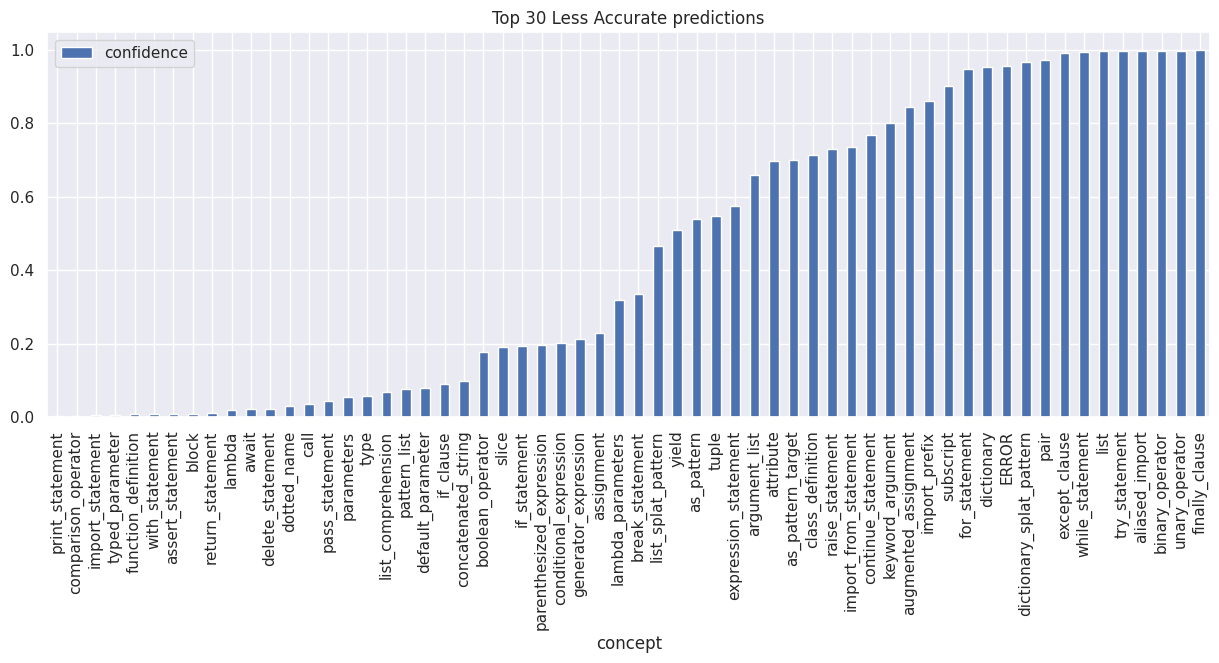

In [85]:
dataframe_intervals = dataframe_intervals.sort_values(by=['confidence'], ascending=True)
dataframe_intervals[:60].plot(x='concept', y=['confidence'], 
kind='bar', title='Top 30 Less Accurate predictions', figsize=(15,5))

<AxesSubplot: title={'center': 'Top 30 Most Accurate predictions'}, xlabel='concept'>

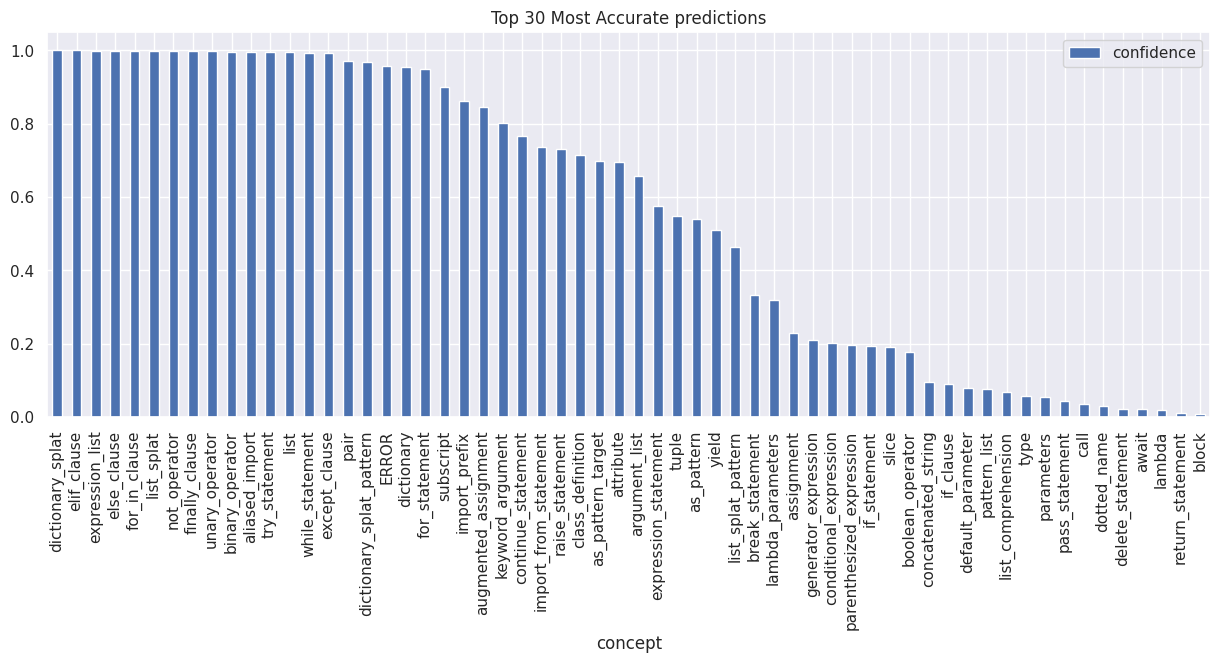

In [86]:
dataframe_intervals = dataframe_intervals.sort_values(by=['confidence'], ascending=False)
dataframe_intervals[:60].plot(x='concept', y=['confidence'], 
kind='bar', title='Top 30 Most Accurate predictions', figsize=(15,5))